In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import numpy as np
import kornia as K

from skimage import io, transform
from tqdm import tqdm
from itertools import chain

from dcgan.inference import predict, show_images

### Данные фона

In [2]:
class COCOval(Dataset):
    '''
    MS COCO validation images without annotation
    '''
    def __init__(self, size, root_dir, transform=None):
        '''
        Args:
            size (int or tuple): Square scaling size for all images
            root_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        '''
        self.root_dir = root_dir
        self.size = size
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                os.listdir(self.root_dir)[idx])
        image = io.imread(img_name)
        image = transform.resize(image, (self.size, self.size))
        
        if self.transform:
            image = self.transform(image)

        return image

### Сети

In [19]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Synthesizer(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.fc = nn.Linear(n, 3 * m ** 2)
        self.sigmoid = nn.Sigmoid()
        self.reshape = Reshape(-1, 3, m, m)
        self.conv = nn.Conv2d(3, 3, 3)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x = x.float()
        x = self.sigmoid(self.fc(x))
        x = self.reshape(x)
        
        #x = self.upsample(x)
        
        # 16
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        
        return x.double()
    
    
class Recognizer(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 96, 5, padding=2)
        self.conv = nn.Conv2d(96, 96, 5, padding=2)
        self.pool = nn.MaxPool2d(3, padding=(1, 0))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(96)
        #self.fc = nn.Linear(192, n) # w/o background
        self.fc = nn.Linear(576, n) # with background
        
    def forward(self, x):
        x = x.float()
        
        #x = self.batchnorm(self.relu(self.pool(self.conv0(x))))
        x = self.relu(self.pool(self.conv0(x)))
        #x = self.batchnorm(self.relu(self.pool(self.conv(x))))
        x = self.relu(self.pool(self.conv(x)))
        #x = self.batchnorm(self.relu(self.pool(self.conv(x))))
        x = self.relu(self.pool(self.conv(x)))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x.double()
    
    
class Renderer(nn.Module):
    def __init__(self, size):
        super(Renderer, self).__init__()        
        self.color_jitter = K.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5)
        self.size = size # size of marker (with background)
  
    def forward(self, x):
        # affine transformation
        affine_sigma = np.random.uniform(0.01, 0.1, 1)
        affine_matrix = torch.tensor([[1, 0, 0], [0, 1, 0]]) +\
            torch.normal(torch.zeros(2, 3), torch.full((2, 3), float(affine_sigma)))
        x = K.geometry.transform.affine(x.float(), affine_matrix)
        
        
        # noise
        for i in range(x.shape[0]):
            # same parameters for each channel
            g = float(np.random.uniform(0.001, 0.003, 1))
            Jahne_sigma = float(np.random.uniform(0.001, 0.3, 1))
            
            print(torch.mean(x[i], axis=[1, 2]))
            
            std = torch.sqrt(g * torch.mean(x[i], axis=[1, 2]) + Jahne_sigma ** 2)
            for j in range(x[i].shape[0]):                    
                x[i][j] = x[i][j] +\
                    torch.normal(torch.zeros(self.size, self.size),
                                 torch.full((self.size, self.size), float(std[j] + 0.001)))
        
        # color transformation
        x = self.color_jitter(x)
        
        # blurring
        blur_sigma = np.random.uniform(0.001, 0.5, 1)
        x = K.filters.gaussian_blur2d(x, (3, 3), (blur_sigma, blur_sigma))
        return x


class MakeFaces(nn.Module):
    def __init__(self, device):
        super(MakeFaces, self).__init__()
        self.reshape = Reshape(-1, 3072)
        self.linear = nn.Linear(3072, 100)
        self.device = device
        
    def forward(self, x):
        x = self.reshape(x)
        x = self.linear(x.float())
        
        x = predict(x, device=self.device, 
              model_path='../trained_nets/generator.pth', 
              params_path='../python/dcgan/params.json')
        
        x = K.geometry.transform.scale(x,
            scale_factor=torch.full((x.shape[0], 1), 0.5))
        x = x[:, :, (m // 2):(m + m//2), (m // 2):(m + m//2)]
        return x

###  Функции обучения и тестирования

In [20]:
def train(device, background_dataloader,
          synt_net, gen_net, rend_net, rec_net, 
          criterion, optimizer, epochs, n, m):

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        accuracy = torch.tensor([])
        
        #for i in (range(int(num_strings / batch_size))):
        for batch in background_dataloader:
            # generate batch with random bit strings
            input_bit_string_batch = torch.tensor(
                np.random.choice([-1, 1], size=(len(batch), n))
            ).to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            synt_outputs = synt_net(input_bit_string_batch)
            gan_outputs = gen_net(synt_outputs)
            gan_outputs_with_background = batch.clone()
            gan_outputs_with_background[:, :, (m // 2):(m + m//2),\
                                         (m // 2):(m + m//2)] = gan_outputs
            rend_outputs = rend_net(gan_outputs_with_background)
            #rend_outputs = rend_net(synt_outputs)
            rec_outputs = rec_net(rend_outputs)
            
            #print('input: ', input_bit_string_batch[0])
            #print('rec: ', torch.sign(rec_outputs[0]))
            
            # criterion = sigmoid
            # the loss is distributed between −1 (perfect recognition) and 0
            loss = torch.mean(-torch.mean(
                criterion(
                    input_bit_string_batch * rec_outputs
                ), axis=1
            ))
            
            # calculate accuracy
            accuracy = torch.cat([
                accuracy, torch.sum(
                    input_bit_string_batch == torch.sign(rec_outputs)
                    , axis=1)
            ])
            
            #print('loss', loss)
            loss.backward()
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('Epoch: ', epoch + 1)
        print('Loss: ', running_loss)
        print('Mean accuracy: {}\n'.format(torch.mean(accuracy / n)))

    print('Finished Training')
    
    
    
def test(device, background_dataloader,
         synt_net, gen_net, rend_net, rec_net, n, m):
    
    errors = torch.tensor([])
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch in background_dataloader:
        #for i in tqdm(range(int(num_strings / batch_size))):
            # generate batch with random bit strings
            input_bit_string_batch = torch.tensor(
                np.random.choice([-1, 1], size=(len(batch), n))
            ).to(device)
            
            # calculate outputs
            synt_outputs = synt_net(input_bit_string_batch)
            gan_outputs = gen_net(synt_outputs)
            #superimposing
            gan_outputs_with_background = batch.clone()
            gan_outputs_with_background[:, :, (m // 2):(m + m//2),\
                                         (m // 2):(m + m//2)] = gan_outputs
            rend_outputs = rend_net(gan_outputs_with_background)
            #rend_outputs = rend_net(synt_outputs)
            rec_outputs = rec_net(rend_outputs)
                        
            # calculate accuracy
            errors = torch.cat([
                errors, torch.sum(
                    input_bit_string_batch == torch.sign(rec_outputs)
                    , axis=1)
            ])
            #print(errors)
            
    print('Mean accuracy: {}\n'.format(torch.mean(errors / n)))

### Параметры

In [21]:
n = 32
m = 32

background_size = m * 2
resize_source_back = background_size * 2

batch_size = 16
#num_strings = 1000
epochs = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Загрузка данных фона

In [22]:
background_train = COCOval(resize_source_back,
               root_dir='../background/train', 
               transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.RandomCrop(background_size)
               ]))

background_dataloader_train = torch.utils.data.DataLoader(background_train, 
                                                    batch_size=batch_size, 
                                                    shuffle=True, 
                                                    num_workers=2)

background_test = COCOval(resize_source_back,
               root_dir='../background/val', 
               transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Resize(background_size)
               ]))

background_dataloader_test = torch.utils.data.DataLoader(background_test, 
                                                    batch_size=batch_size, 
                                                    shuffle=True, 
                                                    num_workers=2)

In [23]:
synt_net = Synthesizer(n, m)
rend_net = Renderer(background_size)
rec_net = Recognizer(n)
gen_net = MakeFaces(device)

synt_net.to(device)
gen_net.to(device)
rend_net.to(device)
rec_net.to(device)

criterion = nn.Sigmoid()

#params = list(synt_net.parameters()) + list(rec_net.parameters())
params = chain(synt_net.parameters(), gen_net.parameters(), rend_net.parameters(), rec_net.parameters())
optimizer = optim.Adam(params, lr=1e-4, weight_decay=1e-5)

In [24]:
train(device, background_dataloader_train,
      synt_net, gen_net, rend_net, rec_net,
      criterion, optimizer, epochs, n, m)


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.3571, 0.3703, 0.3415])
tensor([0.3217, 0.3295, 0.2161])
tensor([0.3966, 0.3591, 0.3463])
tensor([0.3291, 0.4299, 0.5773])
tensor([0.3857, 0.3119, 0.2444])
tensor([0.3237, 0.2392, 0.1517])
tensor([0.5155, 0.3390, 0.3554])
tensor([0.3765, 0.2295, 0.0932])
tensor([0.2139, 0.1796, 0.1726])
tensor([0.4563, 0.4061, 0.3331])
tensor([0.2221, 0.1393, 0.1121])
tensor([0.3156, 0.2322, 0.2245])
tensor([0.4494, 0.3399, 0.2507])
tensor([0.3676, 0.3292, 0.2138])
tensor([0.3739, 0.3713, 0.3626])
tensor([0.3176, 0.2504, 0.2289])
tensor([0.4370, 0.4539, 0.4511])
tensor([0.3139, 0.2876, 0.1989])
tensor([0.4848, 0.3363, 0.2489])
tensor([0.3586, 0.3417, 0.3475])
tensor([0.2585, 0.2002, 0.1027])
tensor([0.1463, 0.1053, 0.0648])
tensor([0.3306, 0.3379, 0.3377])
tensor([0.2841, 0.1849, 0.1899])
tensor([0.3387, 0.2922, 0.2473])
tensor([0.2139, 0.1943, 0.1871])
tensor([0.2431, 0.2027, 0.1744])
tensor([0.4523, 0.3681, 0.2848])
tensor([0.2048, 0.1541, 0.1348])
tensor([0.1579, 0.1440, 0.1166])
tensor([0.

tensor([0.2210, 0.2037, 0.2079])
tensor([0.2695, 0.2334, 0.1910])
tensor([0.3214, 0.1906, 0.0794])
tensor([0.3272, 0.4707, 0.5266])
tensor([0.2921, 0.2588, 0.2237])
tensor([ 0.3278, -0.0477, -0.0702])
tensor([0.4655, 0.4334, 0.4096])
tensor([ 0.3274,  0.1444, -0.0482])
tensor([0.3123, 0.2156, 0.0884])
tensor([0.4007, 0.4376, 0.4624])
tensor([0.3053, 0.2809, 0.2501])
tensor([0.3549, 0.3139, 0.2649])
tensor([0.4062, 0.3695, 0.3086])
tensor([0.4025, 0.4006, 0.4108])
tensor([0.3121, 0.2946, 0.2729])
tensor([0.4413, 0.4262, 0.4227])
tensor([0.3137, 0.2650, 0.2113])
tensor([0.1124, 0.2524, 0.3440])
tensor([0.4080, 0.4234, 0.2535])
tensor([0.3971, 0.4204, 0.4648])
tensor([0.3759, 0.4057, 0.2649])
tensor([0.4215, 0.3648, 0.2837])
tensor([0.2800, 0.3136, 0.1922])
tensor([0.4575, 0.4408, 0.3993])
tensor([0.4052, 0.3362, 0.2630])
tensor([0.2373, 0.2309, 0.2215])
tensor([0.3293, 0.2997, 0.2580])
tensor([0.6434, 0.6119, 0.5863])
tensor([0.2259, 0.1446, 0.0254])
tensor([0.3865, 0.2189, 0.1126])
tens

tensor([0.3858, 0.3385, 0.3127])
tensor([0.3737, 0.2592, 0.2563])
tensor([0.4992, 0.4753, 0.4637])
tensor([0.1531, 0.1386, 0.1292])
tensor([0.3356, 0.3099, 0.2839])
tensor([0.4628, 0.3664, 0.3147])
tensor([0.2932, 0.2249, 0.1888])
tensor([0.2672, 0.2359, 0.1476])
tensor([0.1953, 0.1845, 0.1642])
tensor([0.3449, 0.2926, 0.2697])
tensor([0.4132, 0.4065, 0.3391])
tensor([0.2731, 0.1307, 0.0535])
tensor([0.2467, 0.2101, 0.1908])
tensor([0.2810, 0.2503, 0.2085])
tensor([0.2879, 0.2483, 0.2180])
tensor([0.2533, 0.2521, 0.1413])
tensor([0.2430, 0.2222, 0.1939])
tensor([0.2925, 0.2621, 0.2679])
tensor([0.2781, 0.3266, 0.3544])
tensor([0.1918, 0.1847, 0.1829])
tensor([0.3890, 0.3350, 0.2918])
tensor([0.3440, 0.2668, 0.1985])
tensor([0.4656, 0.3378, 0.2111])
tensor([0.2673, 0.2392, 0.2209])
tensor([0.2008, 0.2140, 0.1947])
tensor([0.5992, 0.5225, 0.4830])
tensor([0.2951, 0.2336, 0.2596])
tensor([0.4018, 0.3263, 0.2984])
tensor([0.5330, 0.5267, 0.5176])
tensor([0.3891, 0.2909, 0.1992])
tensor([0.

tensor([0.2166, 0.1768, 0.1504])
tensor([0.3738, 0.3439, 0.2568])
tensor([0.1022, 0.1206, 0.0487])
tensor([0.3213, 0.2489, 0.1324])
tensor([0.1764, 0.1689, 0.1567])
tensor([0.1977, 0.1751, 0.1711])
tensor([0.4598, 0.3386, 0.3646])
tensor([0.2411, 0.1959, 0.1726])
tensor([0.2598, 0.2912, 0.3252])
tensor([0.2016, 0.1919, 0.2604])
tensor([0.2944, 0.1917, 0.1283])
tensor([0.3531, 0.2239, 0.1704])
tensor([0.3464, 0.3031, 0.2366])
tensor([0.1305, 0.1201, 0.0851])
tensor([0.3477, 0.3301, 0.2836])
tensor([0.1858, 0.1247, 0.0840])
tensor([0.3937, 0.3787, 0.3892])
tensor([0.2826, 0.2798, 0.2406])
tensor([0.3166, 0.2563, 0.2012])
tensor([0.2415, 0.2419, 0.2064])
tensor([0.4601, 0.4055, 0.3614])
tensor([0.3666, 0.3678, 0.3840])
tensor([0.5914, 0.5467, 0.5375])
tensor([0.5016, 0.4765, 0.4567])
tensor([0.3333, 0.3375, 0.2271])
tensor([0.5295, 0.4859, 0.4725])
tensor([0.3732, 0.2989, 0.2704])
tensor([0.3025, 0.1985, 0.1806])
tensor([0.5338, 0.4876, 0.4687])
tensor([0.2852, 0.2442, 0.1965])
tensor([0.

tensor([0.2908, 0.2285, 0.1848])
tensor([0.2198, 0.2213, 0.2097])
tensor([0.3139, 0.2488, 0.2097])
tensor([0.2893, 0.2415, 0.2399])
tensor([0.2059, 0.2006, 0.0722])
tensor([0.3848, 0.3510, 0.3238])
tensor([0.2579, 0.1582, 0.1522])
tensor([0.2582, 0.1572, 0.1115])
tensor([0.2051, 0.1552, 0.1258])
tensor([0.1423, 0.1221, 0.1241])
tensor([0.2515, 0.1589, 0.0982])
tensor([0.2112, 0.1628, 0.0782])
tensor([0.4900, 0.4275, 0.3616])
tensor([0.1413, 0.2076, 0.2999])
tensor([0.1481, 0.1199, 0.0489])
tensor([0.2228, 0.2067, 0.1779])
tensor([0.1811, 0.0854, 0.0356])
tensor([0.2977, 0.2147, 0.0590])
tensor([0.2735, 0.2658, 0.2720])
tensor([0.2684, 0.1889, 0.1478])
tensor([0.4385, 0.3849, 0.3645])
tensor([0.3309, 0.3017, 0.2378])
tensor([ 0.0577,  0.0011, -0.0163])
tensor([0.1975, 0.2854, 0.3441])
tensor([0.5277, 0.3532, 0.1491])
tensor([0.3867, 0.2066, 0.0887])
tensor([0.2325, 0.2989, 0.3959])
tensor([0.5829, 0.5839, 0.6029])
tensor([0.2373, 0.2162, 0.2224])
tensor([0.3806, 0.3641, 0.3705])
tensor(

tensor([0.2438, 0.2421, 0.0549])
tensor([0.3261, 0.2835, 0.2578])
tensor([0.7087, 0.6879, 0.6662])
tensor([0.4164, 0.2788, 0.1630])
tensor([0.3676, 0.2955, 0.2560])
tensor([0.2507, 0.2298, 0.1308])
tensor([0.4998, 0.4353, 0.3901])
tensor([0.3027, 0.3043, 0.2578])
tensor([0.3693, 0.1788, 0.1668])
tensor([0.4725, 0.4489, 0.4387])
tensor([0.1265, 0.1984, 0.1204])
tensor([0.3939, 0.3235, 0.1780])
tensor([0.2506, 0.1445, 0.1037])
tensor([0.3614, 0.3000, 0.2522])
tensor([0.2525, 0.1815, 0.0513])
tensor([0.3728, 0.3451, 0.3381])
tensor([0.4525, 0.3610, 0.2269])
tensor([0.3179, 0.2587, 0.2121])
tensor([0.4806, 0.4487, 0.4381])
tensor([0.2876, 0.2392, 0.2084])
tensor([0.2704, 0.2263, 0.2419])
tensor([0.4286, 0.3977, 0.4180])
tensor([0.2435, 0.1151, 0.0555])
tensor([0.3546, 0.2592, 0.1522])
tensor([0.2595, 0.2309, 0.2057])
tensor([0.2773, 0.2568, 0.1709])
tensor([0.4140, 0.3603, 0.3315])
tensor([0.2090, 0.1289, 0.0826])
tensor([0.4050, 0.3631, 0.3368])
tensor([0.2649, 0.2347, 0.2269])
tensor([0.

tensor([0.3126, 0.2207, 0.1733])
tensor([0.4850, 0.4633, 0.4568])
tensor([0.2607, 0.2128, 0.1442])
tensor([0.6300, 0.3103, 0.0317])
tensor([0.2559, 0.2286, 0.2044])
tensor([0.4953, 0.4195, 0.3232])
tensor([0.3802, 0.3144, 0.2142])
tensor([0.2504, 0.2513, 0.1517])
tensor([0.2725, 0.2285, 0.1414])
tensor([0.2234, 0.2037, 0.1655])
tensor([0.1795, 0.1109, 0.0966])
tensor([0.3909, 0.2620, 0.0855])
tensor([0.2667, 0.2368, 0.2327])
tensor([0.3248, 0.2664, 0.1704])
tensor([0.3653, 0.3308, 0.2998])
tensor([0.5363, 0.2224, 0.2297])
tensor([0.2761, 0.3026, 0.2991])
tensor([0.1119, 0.1778, 0.1121])
tensor([0.4971, 0.3649, 0.2454])
tensor([0.3950, 0.3517, 0.3231])
tensor([0.4207, 0.3830, 0.2142])
tensor([0.3786, 0.4267, 0.4716])
tensor([0.2815, 0.2608, 0.2415])
tensor([0.3606, 0.3421, 0.3396])
tensor([0.5259, 0.3716, 0.3122])
tensor([0.4233, 0.3566, 0.2775])
tensor([0.1369, 0.1151, 0.1076])
tensor([0.3631, 0.3170, 0.2495])
tensor([0.1800, 0.1313, 0.1152])
tensor([0.4659, 0.4329, 0.4143])
tensor([0.

tensor([0.3544, 0.3419, 0.2399])
tensor([0.4217, 0.2806, 0.2503])
tensor([0.4764, 0.3904, 0.3025])
tensor([0.3473, 0.2322, 0.2082])
tensor([0.4377, 0.3568, 0.2679])
tensor([0.2676, 0.2555, 0.2286])
tensor([0.2031, 0.1795, 0.1561])
tensor([0.2942, 0.1719, 0.0697])
tensor([0.2390, 0.1700, 0.1843])
tensor([0.4654, 0.3703, 0.2908])
tensor([0.3412, 0.2937, 0.2514])
tensor([0.3539, 0.3387, 0.3300])
tensor([0.4042, 0.3022, 0.1900])
tensor([0.4199, 0.3950, 0.3834])
tensor([0.4309, 0.3498, 0.3267])
tensor([0.4491, 0.3985, 0.3566])
tensor([0.3693, 0.2978, 0.2582])
tensor([0.2597, 0.2284, 0.2136])
tensor([0.3925, 0.3471, 0.3155])
tensor([0.2384, 0.2264, 0.2202])
tensor([0.2201, 0.2088, 0.2000])
tensor([0.4111, 0.4096, 0.3714])
tensor([0.3901, 0.3595, 0.3134])
tensor([0.1430, 0.1376, 0.1174])
tensor([0.3282, 0.2411, 0.1943])
tensor([0.1310, 0.1110, 0.0900])
tensor([0.2484, 0.2009, 0.1504])
tensor([0.5489, 0.3700, 0.1838])
tensor([0.3334, 0.2908, 0.2222])
tensor([0.4176, 0.4188, 0.4428])
tensor([0.

tensor([0.1986, 0.1593, 0.0914])
tensor([0.2777, 0.2188, 0.1603])
tensor([0.2978, 0.2468, 0.1299])
tensor([0.3667, 0.2029, 0.0824])
tensor([0.3793, 0.3365, 0.3153])
tensor([0.2986, 0.2350, 0.1756])
tensor([0.3292, 0.2371, 0.1296])
tensor([0.3093, 0.2227, 0.2028])
tensor([0.4352, 0.4201, 0.3435])
tensor([0.2278, 0.1590, 0.1034])
tensor([0.3951, 0.2865, 0.2474])
tensor([0.4081, 0.3860, 0.3908])
tensor([0.3443, 0.2936, 0.1730])
tensor([0.4154, 0.2864, 0.1759])
tensor([0.1182, 0.0561, 0.0149])
tensor([0.4668, 0.4368, 0.4365])
tensor([0.3103, 0.1707, 0.1269])
tensor([0.3533, 0.3553, 0.3080])
tensor([0.2907, 0.1446, 0.0620])
tensor([0.4207, 0.3938, 0.3809])
tensor([0.3417, 0.3300, 0.3064])
tensor([0.1952, 0.2299, 0.2503])
tensor([0.4071, 0.3212, 0.1950])
tensor([0.2772, 0.3082, 0.3469])
tensor([0.2703, 0.2297, 0.2150])
tensor([0.4030, 0.2905, 0.2414])
tensor([0.3168, 0.1210, 0.1066])
tensor([0.4161, 0.3907, 0.3628])
tensor([0.3635, 0.2856, 0.2156])
tensor([0.3741, 0.3058, 0.3154])
tensor([0.

tensor([0.4471, 0.3619, 0.2394])
tensor([0.2188, 0.1821, 0.1465])
tensor([0.3293, 0.3227, 0.3289])
tensor([0.2922, 0.1929, 0.1718])
tensor([0.3241, 0.2063, 0.1387])
tensor([0.3226, 0.2952, 0.2701])
tensor([0.4955, 0.3540, 0.1895])
tensor([0.3845, 0.3959, 0.4005])
tensor([0.4927, 0.4879, 0.4745])
tensor([0.2961, 0.2358, 0.2096])
tensor([0.2385, 0.2402, 0.1944])
tensor([0.3288, 0.2919, 0.2689])
tensor([0.3716, 0.2434, 0.1796])
tensor([0.3699, 0.3111, 0.1659])
tensor([0.2303, 0.0814, 0.0296])
tensor([0.3090, 0.2941, 0.3211])
tensor([0.3619, 0.2702, 0.1873])
tensor([0.1671, 0.1861, 0.1578])
tensor([0.3685, 0.3964, 0.3268])
tensor([0.3265, 0.2683, 0.1551])
tensor([0.2469, 0.1549, 0.1508])
tensor([0.2042, 0.1759, 0.0889])
tensor([0.3850, 0.3968, 0.3091])
tensor([0.2684, 0.2890, 0.3251])
tensor([0.3884, 0.3354, 0.2965])
tensor([0.3014, 0.2931, 0.2121])
tensor([0.3344, 0.3034, 0.2715])
tensor([0.3958, 0.3659, 0.3571])
tensor([0.4220, 0.3065, 0.2341])
tensor([0.3215, 0.0980, 0.0672])
tensor([0.

tensor([ 0.0073, -0.0342, -0.0704])
tensor([0.3944, 0.2898, 0.2436])
tensor([0.4712, 0.3742, 0.3675])
tensor([0.2512, 0.2117, 0.2013])
tensor([0.3344, 0.3020, 0.3001])
tensor([0.4273, 0.3722, 0.3717])
tensor([0.1801, 0.2663, 0.4238])
tensor([0.3243, 0.3182, 0.3253])
tensor([0.3186, 0.2644, 0.2531])
tensor([0.2362, 0.2114, 0.1603])
tensor([0.3354, 0.3110, 0.3603])
tensor([0.3927, 0.3947, 0.4176])
tensor([0.3503, 0.2923, 0.2682])
tensor([0.2900, 0.1952, 0.0686])
tensor([0.4734, 0.4131, 0.3261])
tensor([0.1914, 0.1228, 0.1103])
tensor([0.2641, 0.2233, 0.1445])
tensor([0.1696, 0.1137, 0.0851])
tensor([0.2578, 0.2087, 0.1718])
tensor([0.5206, 0.4241, 0.3432])
tensor([0.3362, 0.2763, 0.2151])
tensor([0.4347, 0.2862, 0.1946])
tensor([0.3651, 0.2892, 0.2734])
tensor([0.1888, 0.1537, 0.1029])
tensor([0.2432, 0.2527, 0.1695])
tensor([0.2899, 0.2582, 0.2287])
tensor([0.2165, 0.1422, 0.0658])
tensor([0.3592, 0.3374, 0.3355])
tensor([0.2575, 0.2341, 0.2527])
tensor([0.4687, 0.3783, 0.3346])
tensor(

tensor([0.2737, 0.2055, 0.1693])
tensor([0.4784, 0.3876, 0.3343])
tensor([0.2788, 0.2269, 0.1980])
tensor([0.3377, 0.2764, 0.2476])
tensor([0.3879, 0.3433, 0.3145])
tensor([0.5224, 0.4632, 0.3995])
tensor([0.1954, 0.1912, 0.1679])
tensor([0.2085, 0.1808, 0.1602])
tensor([0.3553, 0.2547, 0.1697])
tensor([0.3120, 0.2645, 0.2285])
tensor([0.2627, 0.2306, 0.2101])
tensor([0.1790, 0.2077, 0.2278])
tensor([0.1996, 0.2133, 0.1957])
tensor([0.4218, 0.2921, 0.2039])
tensor([0.2638, 0.1890, 0.1539])
tensor([0.3452, 0.3247, 0.2724])
tensor([0.4040, 0.3745, 0.3877])
tensor([0.4386, 0.3257, 0.1894])
tensor([0.3565, 0.3750, 0.3988])
tensor([0.2979, 0.2641, 0.2372])
tensor([0.2290, 0.2559, 0.2830])
tensor([0.2273, 0.2015, 0.1572])
tensor([0.3550, 0.2970, 0.2159])
tensor([0.1982, 0.1602, 0.1525])
tensor([0.3082, 0.2894, 0.2117])
tensor([0.2834, 0.2547, 0.1947])
tensor([0.3316, 0.2836, 0.2341])
tensor([0.3663, 0.3702, 0.2441])
tensor([0.2374, 0.0957, 0.0405])
tensor([0.3296, 0.3158, 0.2686])
tensor([0.


  0%|          | 1/1000 [01:58<32:49:58, 118.32s/it]

tensor([0.2417, 0.3335, 0.0938])
tensor([0.3784, 0.2700, 0.2359])
tensor([0.2828, 0.2285, 0.2066])
Epoch:  1
Loss:  -94.1816246921662
Mean accuracy: 0.5022603869438171

tensor([0.2062, 0.1196, 0.0754])
tensor([0.3700, 0.3409, 0.2456])
tensor([0.5665, 0.3569, 0.1559])
tensor([0.4166, 0.2566, 0.1076])
tensor([0.3242, 0.1546, 0.1130])
tensor([0.1537, 0.0908, 0.1074])
tensor([0.3712, 0.3503, 0.2199])
tensor([0.1302, 0.1459, 0.1072])
tensor([0.5077, 0.4759, 0.4580])
tensor([0.2106, 0.1659, 0.1349])
tensor([0.3520, 0.2799, 0.2409])
tensor([0.1842, 0.0899, 0.0190])
tensor([0.3808, 0.2307, 0.1335])
tensor([0.3567, 0.3167, 0.3002])
tensor([0.4948, 0.4255, 0.3904])
tensor([0.2253, 0.1225, 0.0938])
tensor([0.2565, 0.1355, 0.0896])
tensor([0.4933, 0.4165, 0.4081])
tensor([0.4137, 0.3672, 0.3131])
tensor([0.3218, 0.2842, 0.2442])
tensor([0.1922, 0.1080, 0.0596])
tensor([0.2047, 0.3208, 0.2606])
tensor([0.2239, 0.2070, 0.1757])
tensor([0.2961, 0.2612, 0.1984])
tensor([0.4925, 0.3307, 0.2919])
tensor

tensor([0.0937, 0.0454, 0.0140])
tensor([0.2817, 0.2268, 0.1841])
tensor([0.2105, 0.1778, 0.1464])
tensor([0.3686, 0.2896, 0.2512])
tensor([0.4999, 0.4280, 0.3448])
tensor([0.5348, 0.3639, 0.1949])
tensor([0.2134, 0.2210, 0.1426])
tensor([0.1789, 0.1562, 0.1085])
tensor([0.2290, 0.2195, 0.2361])
tensor([0.1439, 0.1718, 0.2005])
tensor([0.3234, 0.2867, 0.2705])
tensor([0.1420, 0.1013, 0.0938])
tensor([0.2251, 0.1876, 0.1491])
tensor([0.1384, 0.1057, 0.0756])
tensor([0.1110, 0.0971, 0.0875])
tensor([0.2391, 0.1689, 0.1143])
tensor([0.2545, 0.2580, 0.2502])
tensor([0.2215, 0.2914, 0.4161])
tensor([0.2493, 0.3005, 0.3799])
tensor([0.3881, 0.3011, 0.1681])
tensor([0.3204, 0.2187, 0.1804])
tensor([0.2012, 0.1699, 0.1543])
tensor([0.2440, 0.2092, 0.1593])
tensor([0.3038, 0.2748, 0.3197])
tensor([0.3433, 0.4166, 0.4428])
tensor([0.2805, 0.3570, 0.3780])
tensor([0.5663, 0.3788, 0.1704])
tensor([0.2669, 0.2592, 0.2842])
tensor([0.4840, 0.4061, 0.3312])
tensor([0.2685, 0.2574, 0.2498])
tensor([0.

tensor([0.3657, 0.3061, 0.2845])
tensor([0.2451, 0.1638, 0.1183])
tensor([ 0.2792,  0.1329, -0.0166])
tensor([0.3771, 0.3484, 0.2959])
tensor([0.3805, 0.2748, 0.1850])
tensor([0.3707, 0.2946, 0.2745])
tensor([0.2640, 0.1976, 0.2301])
tensor([0.3282, 0.3715, 0.1050])
tensor([0.3515, 0.2434, 0.3172])
tensor([0.2355, 0.1899, 0.1654])
tensor([0.3053, 0.2430, 0.1980])
tensor([0.3776, 0.3730, 0.3820])
tensor([0.4378, 0.4517, 0.4488])
tensor([0.3676, 0.3235, 0.3228])
tensor([0.2575, 0.2279, 0.0929])
tensor([0.2491, 0.3119, 0.3187])
tensor([0.1271, 0.0988, 0.1401])
tensor([0.2770, 0.2960, 0.3083])
tensor([0.4054, 0.3601, 0.3300])
tensor([0.2928, 0.2385, 0.2075])
tensor([0.4891, 0.3295, 0.1661])
tensor([0.2669, 0.2032, 0.1439])
tensor([0.4687, 0.3319, 0.2910])
tensor([0.2619, 0.2423, 0.2312])
tensor([0.3505, 0.2823, 0.2614])
tensor([0.5014, 0.2983, 0.1629])
tensor([0.5078, 0.2876, 0.0936])
tensor([0.2861, 0.2502, 0.2127])
tensor([0.2674, 0.2048, 0.1620])
tensor([0.1736, 0.1233, 0.0307])
tensor(

tensor([0.2199, 0.1736, 0.1514])
tensor([0.2854, 0.1357, 0.0321])
tensor([0.3589, 0.2389, 0.2101])
tensor([0.2065, 0.1929, 0.1925])
tensor([0.2319, 0.1571, 0.1043])
tensor([0.2584, 0.2361, 0.2306])
tensor([0.3808, 0.3759, 0.3919])
tensor([0.2569, 0.2410, 0.2485])
tensor([0.2989, 0.2817, 0.2368])
tensor([0.1938, 0.1702, 0.1546])
tensor([0.1953, 0.2125, 0.1501])
tensor([0.4854, 0.4456, 0.4288])
tensor([0.4579, 0.4362, 0.4369])
tensor([0.3693, 0.2825, 0.1712])
tensor([0.2366, 0.1706, 0.1012])
tensor([0.2956, 0.2510, 0.2202])
tensor([0.2850, 0.2331, 0.1929])
tensor([0.3135, 0.2348, 0.1791])
tensor([0.2409, 0.2984, 0.2018])
tensor([0.4721, 0.2811, 0.2715])
tensor([0.2861, 0.1380, 0.0632])
tensor([0.5130, 0.3680, 0.4659])
tensor([0.3127, 0.3039, 0.2549])
tensor([0.2939, 0.2578, 0.2344])
tensor([0.2416, 0.2484, 0.1002])
tensor([0.5776, 0.4765, 0.4045])
tensor([0.5035, 0.4536, 0.3359])
tensor([0.1360, 0.1329, 0.1346])
tensor([0.2229, 0.2428, 0.2999])
tensor([0.4352, 0.4139, 0.3986])
tensor([0.

tensor([0.2095, 0.1622, 0.1484])
tensor([0.3275, 0.1779, 0.1412])
tensor([0.3404, 0.2185, 0.1492])
tensor([0.3731, 0.3329, 0.3267])
tensor([0.3936, 0.3412, 0.3179])
tensor([0.3241, 0.3230, 0.3049])
tensor([0.2106, 0.1271, 0.0953])
tensor([0.1917, 0.2541, 0.2608])
tensor([0.5005, 0.4666, 0.4569])
tensor([0.3773, 0.3095, 0.2582])
tensor([0.3537, 0.2927, 0.2933])
tensor([0.3034, 0.2913, 0.3401])
tensor([0.4679, 0.2768, 0.1183])
tensor([0.4575, 0.3054, 0.2626])
tensor([0.2611, 0.2322, 0.0977])
tensor([0.3657, 0.3947, 0.4232])
tensor([0.2515, 0.0835, 0.0040])
tensor([0.1879, 0.2046, 0.1001])
tensor([0.2397, 0.2374, 0.2149])
tensor([0.2946, 0.2502, 0.2332])
tensor([0.3672, 0.3271, 0.2928])
tensor([0.2393, 0.1517, 0.0327])
tensor([0.2584, 0.2273, 0.1918])
tensor([0.1110, 0.0940, 0.0774])
tensor([0.2938, 0.3630, 0.4203])
tensor([0.6325, 0.6090, 0.5955])
tensor([0.2934, 0.2568, 0.2200])
tensor([0.3604, 0.3014, 0.3127])
tensor([0.4630, 0.3194, 0.1537])
tensor([0.5088, 0.1785, 0.1608])
tensor([0.

tensor([0.1770, 0.1193, 0.1000])
tensor([0.2402, 0.2276, 0.1349])
tensor([0.2627, 0.1905, 0.0926])
tensor([0.4710, 0.1905, 0.1672])
tensor([0.2456, 0.2229, 0.1671])
tensor([0.3908, 0.3328, 0.2765])
tensor([0.3746, 0.3402, 0.3380])
tensor([0.2966, 0.2333, 0.1970])
tensor([0.3140, 0.1791, 0.1493])
tensor([0.2988, 0.2596, 0.2431])
tensor([0.3342, 0.4109, 0.1967])
tensor([0.2755, 0.1692, 0.0312])
tensor([0.3944, 0.3892, 0.4158])
tensor([0.0844, 0.0849, 0.0176])
tensor([0.4269, 0.3743, 0.3519])
tensor([0.2649, 0.1945, 0.1508])
tensor([0.3509, 0.2121, 0.1170])
tensor([0.3373, 0.2562, 0.1073])
tensor([0.2753, 0.2406, 0.2497])
tensor([0.2854, 0.3383, 0.2074])
tensor([0.4550, 0.4185, 0.3096])
tensor([0.3569, 0.3295, 0.3175])
tensor([0.3039, 0.2803, 0.2854])
tensor([0.2540, 0.2303, 0.2156])
tensor([0.2773, 0.2363, 0.2197])
tensor([0.3117, 0.2785, 0.2867])
tensor([0.3265, 0.2656, 0.1827])
tensor([0.1836, 0.1812, 0.1879])
tensor([0.3133, 0.2771, 0.2783])
tensor([0.2822, 0.2657, 0.2589])
tensor([0.

tensor([0.2401, 0.2106, 0.1994])
tensor([0.4919, 0.3996, 0.2140])
tensor([0.2030, 0.2400, 0.2666])
tensor([0.2543, 0.2359, 0.2212])
tensor([0.1400, 0.2019, 0.1164])
tensor([0.2903, 0.2409, 0.1742])
tensor([0.2624, 0.1844, 0.1514])
tensor([0.3325, 0.3093, 0.2684])
tensor([0.2029, 0.1766, 0.1700])
tensor([0.2097, 0.1609, 0.1397])
tensor([0.3210, 0.2844, 0.2813])
tensor([0.1448, 0.0645, 0.0252])
tensor([0.4340, 0.3480, 0.3185])
tensor([0.2768, 0.2478, 0.2351])
tensor([0.3647, 0.3517, 0.3452])
tensor([0.2864, 0.2078, 0.1489])
tensor([0.5121, 0.4925, 0.3737])
tensor([0.4021, 0.3767, 0.3717])
tensor([0.2973, 0.2343, 0.1897])
tensor([0.3134, 0.2742, 0.2603])
tensor([0.2722, 0.2339, 0.1737])
tensor([0.2147, 0.3453, 0.5291])
tensor([0.5830, 0.5339, 0.4917])
tensor([0.2760, 0.1836, 0.1158])
tensor([0.4044, 0.3854, 0.3800])
tensor([0.2107, 0.0903, 0.0166])
tensor([0.3431, 0.3154, 0.2854])
tensor([0.3424, 0.3052, 0.2706])
tensor([0.3371, 0.3032, 0.2935])
tensor([0.1651, 0.1202, 0.0604])
tensor([0.

tensor([0.3388, 0.2883, 0.2387])
tensor([0.2047, 0.1527, 0.1495])
tensor([0.2370, 0.1956, 0.1142])
tensor([0.3286, 0.2547, 0.2461])
tensor([0.1761, 0.1549, 0.1373])
tensor([0.1922, 0.1752, 0.2042])
tensor([0.2859, 0.2713, 0.2066])
tensor([0.3515, 0.2804, 0.2705])
tensor([0.1456, 0.1217, 0.1264])
tensor([0.1906, 0.0812, 0.0361])
tensor([0.3641, 0.3096, 0.2429])
tensor([0.2366, 0.2147, 0.1919])
tensor([0.2682, 0.2281, 0.1851])
tensor([0.1387, 0.1036, 0.0917])
tensor([0.2472, 0.2120, 0.1390])
tensor([0.1383, 0.1705, 0.0925])
tensor([0.2134, 0.2333, 0.1924])
tensor([0.2789, 0.2279, 0.1936])
tensor([0.2819, 0.2204, 0.2090])
tensor([0.2614, 0.2745, 0.3460])
tensor([0.3534, 0.2764, 0.2148])
tensor([0.5237, 0.3955, 0.1725])
tensor([0.2990, 0.2590, 0.2556])
tensor([0.3977, 0.2116, 0.0589])
tensor([0.2964, 0.2597, 0.2422])
tensor([0.4029, 0.3493, 0.3050])
tensor([0.4182, 0.3858, 0.3475])
tensor([0.2363, 0.2046, 0.1669])
tensor([0.3298, 0.2055, 0.1210])
tensor([0.2659, 0.1866, 0.1289])
tensor([0.

tensor([0.3156, 0.2821, 0.2632])
tensor([0.3691, 0.2186, 0.1046])
tensor([0.3250, 0.2501, 0.1053])
tensor([0.2687, 0.2794, 0.2771])
tensor([0.3518, 0.2910, 0.1675])
tensor([0.5996, 0.4153, 0.3629])
tensor([0.4240, 0.3679, 0.3455])
tensor([0.4990, 0.4090, 0.2052])
tensor([0.1416, 0.1979, 0.2616])
tensor([0.2752, 0.2475, 0.1206])
tensor([0.2853, 0.2136, 0.1799])
tensor([0.3420, 0.2474, 0.2025])
tensor([0.1164, 0.1311, 0.0932])
tensor([0.4043, 0.2846, 0.2698])
tensor([0.4789, 0.3482, 0.1917])
tensor([0.2996, 0.2038, 0.1581])
tensor([0.3101, 0.2964, 0.2756])
tensor([0.3314, 0.3191, 0.2825])
tensor([0.2750, 0.1557, 0.1683])
tensor([0.2495, 0.2242, 0.2156])
tensor([0.3726, 0.3592, 0.3212])
tensor([0.2945, 0.2868, 0.2516])
tensor([0.2894, 0.2761, 0.3092])
tensor([0.2702, 0.2156, 0.1800])
tensor([0.3848, 0.3452, 0.3043])
tensor([0.1918, 0.2173, 0.1180])
tensor([0.2060, 0.2428, 0.2165])
tensor([0.2873, 0.2600, 0.2011])
tensor([0.3016, 0.2002, 0.1515])
tensor([0.2763, 0.2924, 0.1806])
tensor([0.

tensor([0.3383, 0.2859, 0.1916])
tensor([0.4168, 0.4005, 0.3388])
tensor([0.2126, 0.1837, 0.1418])
tensor([0.2668, 0.2399, 0.2428])
tensor([0.1186, 0.0376, 0.0265])
tensor([0.2851, 0.1939, 0.1507])
tensor([0.4473, 0.2664, 0.1646])
tensor([0.4167, 0.3896, 0.3699])
tensor([0.2632, 0.2406, 0.2162])
tensor([0.1512, 0.0754, 0.0701])
tensor([0.1818, 0.2011, 0.2456])
tensor([0.3795, 0.3216, 0.2400])
tensor([0.2727, 0.2431, 0.2306])
tensor([0.3560, 0.2601, 0.2210])
tensor([ 0.1056,  0.0566, -0.0212])
tensor([0.2542, 0.1958, 0.1797])
tensor([0.3155, 0.3159, 0.2931])
tensor([0.1383, 0.0532, 0.0309])
tensor([0.2568, 0.2012, 0.1120])
tensor([0.4081, 0.3757, 0.2632])
tensor([0.2310, 0.2269, 0.1992])
tensor([0.2739, 0.2631, 0.2547])
tensor([0.3969, 0.4321, 0.4203])
tensor([0.3862, 0.3022, 0.1834])
tensor([0.5652, 0.5513, 0.5611])
tensor([0.3319, 0.2642, 0.2812])
tensor([0.3057, 0.1636, 0.0883])
tensor([0.1658, 0.1809, 0.1967])
tensor([0.3760, 0.2645, 0.1976])
tensor([0.3798, 0.2856, 0.2265])
tensor(

tensor([ 0.0648, -0.0143,  0.0195])
tensor([0.4110, 0.3850, 0.3716])
tensor([0.3147, 0.2810, 0.2753])
tensor([0.4088, 0.3733, 0.3362])
tensor([0.4224, 0.3413, 0.2996])
tensor([0.3742, 0.2454, 0.2447])
tensor([0.1972, 0.1587, 0.1350])
tensor([0.2010, 0.1429, 0.0796])
tensor([0.2288, 0.3197, 0.4281])
tensor([0.3431, 0.3121, 0.3002])
tensor([0.2836, 0.1809, 0.1239])
tensor([0.2782, 0.1896, 0.1742])
tensor([0.2205, 0.2006, 0.1845])
tensor([0.2410, 0.2134, 0.0756])
tensor([0.1563, 0.1531, 0.1057])
tensor([0.4259, 0.3944, 0.3550])
tensor([0.4506, 0.3616, 0.3156])
tensor([0.4503, 0.3731, 0.3247])
tensor([0.3689, 0.2878, 0.1982])
tensor([0.3852, 0.4127, 0.4160])
tensor([0.3110, 0.3447, 0.3350])
tensor([0.3446, 0.3600, 0.1607])
tensor([0.2940, 0.3115, 0.2806])
tensor([0.3468, 0.2879, 0.2572])
tensor([0.4229, 0.3059, 0.2315])
tensor([0.2099, 0.3176, 0.4572])
tensor([0.2238, 0.1886, 0.1486])
tensor([0.4255, 0.3602, 0.3142])
tensor([0.4224, 0.3605, 0.2551])
tensor([0.3032, 0.2480, 0.1865])
tensor(

tensor([0.0949, 0.0663, 0.0652])
tensor([0.5242, 0.4640, 0.4321])
tensor([0.4737, 0.3276, 0.1654])
tensor([0.2289, 0.2402, 0.2142])
tensor([0.3202, 0.3540, 0.3509])
tensor([0.3698, 0.4797, 0.5459])
tensor([0.4233, 0.4112, 0.4002])
tensor([0.5400, 0.4575, 0.3871])
tensor([0.2501, 0.1940, 0.1651])
tensor([0.2973, 0.2180, 0.2547])
tensor([ 0.1606,  0.0672, -0.0031])
tensor([0.3168, 0.2804, 0.2700])
tensor([0.2494, 0.1980, 0.0696])
tensor([0.3720, 0.3017, 0.2726])
tensor([0.5866, 0.4989, 0.3234])
tensor([0.1911, 0.1655, 0.1622])
tensor([0.3668, 0.2759, 0.1926])
tensor([ 0.1396,  0.0540, -0.0181])
tensor([0.2250, 0.2094, 0.1729])
tensor([0.3446, 0.3068, 0.3103])
tensor([0.3471, 0.3169, 0.2782])
tensor([0.4127, 0.3504, 0.3545])
tensor([0.1196, 0.0330, 0.0010])
tensor([0.2584, 0.1887, 0.1289])
tensor([0.3555, 0.3094, 0.2533])
tensor([0.3016, 0.2288, 0.1300])
tensor([0.3906, 0.2790, 0.1733])
tensor([0.3570, 0.3553, 0.3901])
tensor([0.3547, 0.3448, 0.3355])
tensor([0.3147, 0.2239, 0.0992])
tens


  0%|          | 2/1000 [04:18<34:34:48, 124.74s/it]

tensor([0.3714, 0.3254, 0.2912])
tensor([0.3759, 0.3884, 0.4064])
tensor([0.2247, 0.2567, 0.2195])
tensor([0.2692, 0.2918, 0.2573])
tensor([0.3061, 0.2295, 0.1969])
tensor([0.1865, 0.1611, 0.1519])
tensor([0.3119, 0.2847, 0.2527])
tensor([0.2403, 0.2088, 0.1496])
Epoch:  2
Loss:  -95.15155524102445
Mean accuracy: 0.5077083110809326

tensor([0.4057, 0.3618, 0.2551])
tensor([0.2479, 0.2537, 0.1947])
tensor([0.3392, 0.3162, 0.3175])
tensor([0.2738, 0.2095, 0.1211])
tensor([0.2934, 0.2270, 0.2040])
tensor([0.2927, 0.2836, 0.0951])
tensor([0.2825, 0.2201, 0.2019])
tensor([0.0962, 0.0594, 0.0477])
tensor([0.3348, 0.2940, 0.2491])
tensor([0.1263, 0.0503, 0.0036])
tensor([0.4735, 0.4476, 0.4333])
tensor([0.2222, 0.1847, 0.1380])
tensor([0.2630, 0.2035, 0.1655])
tensor([0.3015, 0.3052, 0.2659])
tensor([0.3607, 0.3141, 0.2530])
tensor([0.2580, 0.1526, 0.0654])
tensor([0.3790, 0.3130, 0.2635])
tensor([0.2091, 0.1321, 0.1092])
tensor([0.4391, 0.4001, 0.3620])
tensor([0.3678, 0.3714, 0.3918])
tenso

tensor([0.3006, 0.2453, 0.2326])
tensor([0.2059, 0.1279, 0.0744])
tensor([0.2353, 0.2371, 0.2819])
tensor([0.1505, 0.1832, 0.1431])
tensor([0.4438, 0.4622, 0.2591])
tensor([0.2088, 0.1603, 0.1624])
tensor([0.1267, 0.0960, 0.0674])
tensor([0.3690, 0.3375, 0.3398])
tensor([0.2741, 0.2578, 0.2543])
tensor([0.3052, 0.1850, 0.0811])
tensor([0.3647, 0.3384, 0.3171])
tensor([0.3443, 0.2751, 0.2205])
tensor([0.3459, 0.2312, 0.1354])
tensor([0.4517, 0.3468, 0.2797])
tensor([0.3169, 0.2117, 0.1675])
tensor([0.2021, 0.2060, 0.0850])
tensor([0.0347, 0.0230, 0.1187])
tensor([0.2977, 0.2628, 0.2357])
tensor([0.3412, 0.2659, 0.1798])
tensor([0.2838, 0.2086, 0.1974])
tensor([0.1753, 0.1588, 0.0924])
tensor([0.1961, 0.1652, 0.1487])
tensor([0.2067, 0.1602, 0.1391])
tensor([0.3769, 0.3255, 0.2900])
tensor([0.2957, 0.2228, 0.1823])
tensor([0.3545, 0.3082, 0.2585])
tensor([0.3590, 0.2411, 0.1213])
tensor([0.1378, 0.0669, 0.0210])
tensor([0.3293, 0.3020, 0.2381])
tensor([0.4503, 0.2134, 0.2216])
tensor([0.

tensor([0.3934, 0.3924, 0.3887])
tensor([0.4680, 0.4409, 0.4326])
tensor([0.4298, 0.2864, 0.1504])
tensor([0.2488, 0.1769, 0.1458])
tensor([0.3612, 0.2975, 0.2707])
tensor([0.2635, 0.2225, 0.2010])
tensor([0.2563, 0.1613, 0.1126])
tensor([0.2171, 0.2130, 0.2317])
tensor([0.4659, 0.3614, 0.2919])
tensor([0.2769, 0.1817, 0.1022])
tensor([0.3327, 0.2775, 0.2512])
tensor([0.3720, 0.3136, 0.3147])
tensor([0.2317, 0.1524, 0.0992])
tensor([0.3354, 0.2691, 0.2353])
tensor([0.4766, 0.4413, 0.4225])
tensor([0.4098, 0.3743, 0.3666])
tensor([0.4091, 0.3369, 0.3110])
tensor([0.2838, 0.2477, 0.1405])
tensor([0.5244, 0.3740, 0.3177])
tensor([0.4169, 0.3620, 0.3190])
tensor([0.2613, 0.1590, 0.1262])
tensor([0.4443, 0.4163, 0.4066])
tensor([0.3284, 0.2962, 0.2543])
tensor([0.3519, 0.3245, 0.2751])
tensor([0.2757, 0.1730, 0.0867])
tensor([0.3047, 0.3713, 0.1042])
tensor([0.5499, 0.4979, 0.4875])
tensor([0.3817, 0.3048, 0.2889])
tensor([0.4255, 0.2808, 0.1518])
tensor([0.3520, 0.2786, 0.2533])
tensor([0.

tensor([0.4500, 0.2157, 0.0778])
tensor([0.3284, 0.2965, 0.2800])
tensor([0.2448, 0.2282, 0.2217])
tensor([0.2160, 0.1581, 0.1187])
tensor([0.3647, 0.3565, 0.3299])
tensor([0.4499, 0.3964, 0.4048])
tensor([0.3683, 0.3550, 0.1422])
tensor([0.3118, 0.2083, 0.1710])
tensor([0.2282, 0.1732, 0.1164])
tensor([0.3999, 0.4254, 0.3114])
tensor([0.1700, 0.1706, 0.1779])
tensor([0.4154, 0.3820, 0.3193])
tensor([0.2886, 0.2423, 0.0981])
tensor([0.2549, 0.1179, 0.0753])
tensor([0.2082, 0.1830, 0.1539])
tensor([0.3560, 0.2055, 0.1269])
tensor([0.5091, 0.5069, 0.5043])
tensor([0.3094, 0.2617, 0.1845])
tensor([0.3797, 0.3131, 0.2769])
tensor([0.4788, 0.3613, 0.2525])
tensor([ 0.2505, -0.0267, -0.0432])
tensor([0.2677, 0.2385, 0.2296])
tensor([0.2299, 0.2548, 0.2097])
tensor([0.2773, 0.1460, 0.1193])
tensor([0.3762, 0.2921, 0.2039])
tensor([0.3948, 0.3067, 0.2331])
tensor([0.2995, 0.2601, 0.2012])
tensor([0.3791, 0.2715, 0.2289])
tensor([0.4350, 0.4211, 0.4036])
tensor([0.2604, 0.2436, 0.2279])
tensor(

tensor([0.3146, 0.2834, 0.2883])
tensor([0.4047, 0.3923, 0.3890])
tensor([0.3706, 0.2810, 0.1910])
tensor([0.2790, 0.2340, 0.1921])
tensor([0.3598, 0.2747, 0.1149])
tensor([0.3585, 0.3453, 0.3025])
tensor([0.2278, 0.1204, 0.0922])
tensor([0.1726, 0.1446, 0.1405])
tensor([0.4111, 0.2945, 0.1931])
tensor([0.4161, 0.1008, 0.0194])
tensor([0.2267, 0.1963, 0.0769])
tensor([0.4698, 0.4229, 0.4130])
tensor([0.2610, 0.2084, 0.1958])
tensor([0.1245, 0.0794, 0.0416])
tensor([0.3315, 0.2667, 0.2369])
tensor([0.4787, 0.3526, 0.1975])
tensor([0.3892, 0.3438, 0.2960])
tensor([0.5282, 0.5414, 0.5386])
tensor([0.2404, 0.2047, 0.1948])
tensor([0.2707, 0.3076, 0.3889])
tensor([0.1441, 0.0965, 0.0698])
tensor([0.3531, 0.3211, 0.2679])
tensor([0.3916, 0.4225, 0.3908])
tensor([0.1357, 0.0962, 0.0343])
tensor([0.4267, 0.4004, 0.4248])
tensor([0.3223, 0.2875, 0.2979])
tensor([0.2359, 0.1851, 0.1306])
tensor([0.2399, 0.1762, 0.1564])
tensor([0.1583, 0.1487, 0.1478])
tensor([0.2449, 0.2000, 0.1422])
tensor([0.

tensor([0.3496, 0.3097, 0.2234])
tensor([0.3870, 0.3492, 0.3332])
tensor([0.3705, 0.4122, 0.3644])
tensor([0.3888, 0.3493, 0.2675])
tensor([0.1098, 0.0655, 0.0439])
tensor([0.2113, 0.1565, 0.1338])
tensor([0.1051, 0.0741, 0.0795])
tensor([0.2368, 0.1430, 0.1234])
tensor([0.4053, 0.3662, 0.3144])
tensor([0.6098, 0.3043, 0.0269])
tensor([0.4012, 0.3662, 0.3349])
tensor([0.3897, 0.3705, 0.3529])
tensor([0.3690, 0.2717, 0.1690])
tensor([0.3414, 0.2559, 0.2033])
tensor([0.4391, 0.2686, 0.1318])
tensor([0.3315, 0.2855, 0.1301])
tensor([0.2168, 0.2052, 0.1916])
tensor([0.2469, 0.1568, 0.1488])
tensor([0.3519, 0.3026, 0.2591])
tensor([0.2937, 0.2047, 0.2238])
tensor([0.2853, 0.2016, 0.1682])
tensor([0.2394, 0.1718, 0.1200])
tensor([0.5875, 0.4120, 0.2176])
tensor([0.4238, 0.3997, 0.3766])
tensor([0.4545, 0.4407, 0.2710])
tensor([0.4053, 0.3103, 0.2261])
tensor([0.1356, 0.0469, 0.0350])
tensor([0.3659, 0.2809, 0.2681])
tensor([0.3100, 0.2828, 0.2360])
tensor([0.4000, 0.3442, 0.2541])
tensor([0.

tensor([0.4298, 0.3847, 0.3308])
tensor([0.3855, 0.3704, 0.3619])
tensor([0.1523, 0.1312, 0.0872])
tensor([0.1811, 0.1073, 0.0680])
tensor([0.3502, 0.3334, 0.3361])
tensor([0.3158, 0.2201, 0.1560])
tensor([0.1454, 0.1179, 0.0601])
tensor([0.3795, 0.3088, 0.2650])
tensor([0.2548, 0.2082, 0.1538])
tensor([0.3150, 0.2107, 0.1543])
tensor([0.3061, 0.3431, 0.3957])
tensor([0.1099, 0.0783, 0.0787])
tensor([0.5263, 0.4822, 0.4204])
tensor([0.2513, 0.1681, 0.1263])
tensor([0.4347, 0.4330, 0.2942])
tensor([0.4048, 0.2495, 0.1585])
tensor([0.2774, 0.1988, 0.1674])
tensor([0.2646, 0.2339, 0.2311])
tensor([0.3490, 0.2144, 0.2273])
tensor([0.2741, 0.2414, 0.2315])
tensor([0.2859, 0.2395, 0.2328])
tensor([0.3321, 0.2624, 0.2154])
tensor([0.4677, 0.4060, 0.3696])
tensor([0.3186, 0.3373, 0.3262])
tensor([0.3145, 0.2810, 0.2610])
tensor([0.2763, 0.2563, 0.2779])
tensor([0.2531, 0.2266, 0.1954])
tensor([0.3415, 0.3049, 0.3024])
tensor([0.3774, 0.3522, 0.3340])
tensor([0.1169, 0.0922, 0.0254])
tensor([0.

tensor([0.3068, 0.3212, 0.1262])
tensor([0.2607, 0.2284, 0.2047])
tensor([0.2507, 0.2313, 0.2172])
tensor([0.4209, 0.3571, 0.3368])
tensor([0.4341, 0.4083, 0.2477])
tensor([0.3579, 0.3077, 0.2759])
tensor([0.3248, 0.2437, 0.1654])
tensor([0.2455, 0.1664, 0.0986])
tensor([0.4157, 0.3649, 0.2885])
tensor([0.2927, 0.1704, 0.1408])
tensor([0.2061, 0.1845, 0.2081])
tensor([0.4660, 0.4190, 0.2765])
tensor([0.3628, 0.3388, 0.3360])
tensor([0.1994, 0.1802, 0.1914])
tensor([0.2279, 0.0755, 0.0085])
tensor([0.3272, 0.3246, 0.3348])
tensor([0.1751, 0.1967, 0.0797])
tensor([0.3998, 0.3768, 0.3238])
tensor([0.3239, 0.2935, 0.2919])
tensor([0.1377, 0.0959, 0.0653])
tensor([0.3680, 0.2988, 0.2119])
tensor([0.1882, 0.2914, 0.3594])
tensor([0.3952, 0.3550, 0.2300])
tensor([0.2873, 0.2605, 0.1486])
tensor([0.3452, 0.3215, 0.2630])
tensor([ 0.2124,  0.1094, -0.0492])
tensor([0.2932, 0.2834, 0.1024])
tensor([0.4891, 0.3867, 0.3369])
tensor([0.2405, 0.2129, 0.1882])
tensor([0.3849, 0.3836, 0.4041])
tensor(

tensor([0.2890, 0.1902, 0.1059])
tensor([0.3871, 0.2454, 0.1950])
tensor([0.3636, 0.3410, 0.1928])
tensor([0.1682, 0.1388, 0.1276])
tensor([0.2458, 0.2527, 0.2560])
tensor([0.2446, 0.2016, 0.1725])
tensor([0.3871, 0.3481, 0.2910])
tensor([0.2767, 0.1646, 0.0930])
tensor([0.4492, 0.3796, 0.2884])
tensor([0.3117, 0.2732, 0.2503])
tensor([0.2469, 0.2301, 0.2264])
tensor([0.2597, 0.1718, 0.1192])
tensor([0.3146, 0.3066, 0.2616])
tensor([0.2163, 0.1706, 0.1590])
tensor([0.2806, 0.2673, 0.1554])
tensor([0.2803, 0.2583, 0.2118])
tensor([0.1644, 0.1467, 0.1388])
tensor([0.0848, 0.1387, 0.2211])
tensor([0.4721, 0.4273, 0.3960])
tensor([0.3705, 0.3627, 0.3069])
tensor([0.3494, 0.2712, 0.1999])
tensor([0.4396, 0.1992, 0.0658])
tensor([0.2574, 0.2125, 0.1764])
tensor([0.4124, 0.3584, 0.3105])
tensor([0.4483, 0.3659, 0.2755])
tensor([0.1567, 0.2123, 0.1506])
tensor([0.3225, 0.3714, 0.4075])
tensor([0.3102, 0.3458, 0.3919])
tensor([0.3653, 0.3569, 0.3704])
tensor([0.5818, 0.4394, 0.2612])
tensor([0.

tensor([0.4143, 0.3359, 0.2683])
tensor([0.2612, 0.2241, 0.2028])
tensor([0.4480, 0.3672, 0.3018])
tensor([0.3705, 0.2597, 0.1680])
tensor([0.4890, 0.4259, 0.3374])
tensor([0.4212, 0.3912, 0.3771])
tensor([0.2846, 0.1937, 0.1462])
tensor([0.2342, 0.2040, 0.1583])
tensor([0.3742, 0.3381, 0.3097])
tensor([0.1763, 0.1338, 0.1016])
tensor([0.1157, 0.0682, 0.0296])
tensor([0.3798, 0.2500, 0.2501])
tensor([0.2884, 0.1979, 0.1271])
tensor([0.2768, 0.2534, 0.2210])
tensor([0.2980, 0.2484, 0.1682])
tensor([0.1184, 0.2313, 0.0797])
tensor([0.2990, 0.3472, 0.3637])
tensor([0.2190, 0.1779, 0.1754])
tensor([0.3312, 0.2038, 0.1370])
tensor([0.3858, 0.3816, 0.4074])
tensor([0.3853, 0.3181, 0.3188])
tensor([0.2779, 0.2742, 0.2892])
tensor([0.2990, 0.2284, 0.2114])
tensor([0.2776, 0.1555, 0.1216])
tensor([0.4264, 0.3721, 0.2239])
tensor([0.4986, 0.4629, 0.3747])
tensor([0.4145, 0.3986, 0.3873])
tensor([0.2670, 0.2370, 0.2099])
tensor([0.2585, 0.2383, 0.2136])
tensor([0.3428, 0.3657, 0.3856])
tensor([0.

tensor([0.5973, 0.5425, 0.4722])
tensor([0.0956, 0.1272, 0.1905])
tensor([0.3284, 0.3162, 0.3190])
tensor([0.2830, 0.3659, 0.4137])
tensor([0.3090, 0.2958, 0.1957])
tensor([0.4141, 0.4490, 0.4900])
tensor([0.2367, 0.2332, 0.2080])
tensor([0.1810, 0.1212, 0.0825])
tensor([0.2095, 0.1333, 0.0744])
tensor([ 0.2349,  0.1530, -0.0049])
tensor([0.3237, 0.1999, 0.1012])
tensor([0.3800, 0.4349, 0.4935])
tensor([0.1974, 0.0828, 0.0987])
tensor([0.2274, 0.2028, 0.1891])
tensor([0.3449, 0.3062, 0.2896])
tensor([0.3494, 0.2548, 0.1756])
tensor([0.3631, 0.3219, 0.2990])
tensor([0.0810, 0.0421, 0.0159])
tensor([ 0.1844,  0.0689, -0.0062])
tensor([0.4680, 0.2676, 0.2221])
tensor([0.2280, 0.1806, 0.1676])
tensor([0.4406, 0.3910, 0.3588])
tensor([0.3395, 0.2977, 0.2520])
tensor([0.3620, 0.3230, 0.2389])
tensor([0.2605, 0.3043, 0.3865])
tensor([0.3128, 0.2356, 0.1509])
tensor([0.2633, 0.3370, 0.2660])
tensor([0.3204, 0.2454, 0.1206])
tensor([0.3262, 0.2681, 0.2049])
tensor([0.3119, 0.2503, 0.1416])
tens

tensor([0.3634, 0.2352, 0.0371])
tensor([0.3713, 0.2913, 0.2292])
tensor([0.4077, 0.3596, 0.2985])
tensor([0.2942, 0.2548, 0.1919])
tensor([0.2945, 0.2143, 0.0769])
tensor([0.3382, 0.2999, 0.2594])
tensor([0.2169, 0.1640, 0.1325])
tensor([0.3291, 0.3010, 0.2864])
tensor([0.2780, 0.1680, 0.0991])
tensor([0.2887, 0.2494, 0.2372])
tensor([0.3454, 0.2978, 0.2601])
tensor([0.4557, 0.3995, 0.3533])
tensor([0.2852, 0.2875, 0.3184])
tensor([0.3082, 0.2521, 0.1937])
tensor([0.4315, 0.4857, 0.4496])
tensor([0.1734, 0.2393, 0.1974])
tensor([0.4762, 0.4173, 0.3778])
tensor([0.3879, 0.3470, 0.3243])
tensor([0.2007, 0.1471, 0.0732])
tensor([0.2417, 0.1008, 0.0633])
tensor([0.2412, 0.1826, 0.1394])
tensor([0.2859, 0.1793, 0.1405])
tensor([0.1598, 0.1532, 0.1162])
tensor([0.3251, 0.3398, 0.3587])
tensor([0.3365, 0.2342, 0.1319])
tensor([0.3283, 0.3263, 0.2318])
tensor([0.3339, 0.2752, 0.2319])
tensor([0.2419, 0.2111, 0.1573])
tensor([0.2040, 0.1538, 0.0615])
tensor([0.5307, 0.4409, 0.4028])
tensor([0.


  0%|          | 3/1000 [06:32<35:22:28, 127.73s/it]

tensor([0.3016, 0.2249, 0.0995])
tensor([0.2378, 0.2222, 0.1630])
tensor([0.3285, 0.2199, 0.0813])
tensor([0.1823, 0.1354, 0.0668])
tensor([0.1790, 0.1980, 0.1180])
tensor([0.2140, 0.1439, 0.1103])
tensor([0.3568, 0.3420, 0.3163])
tensor([0.2210, 0.1969, 0.1134])
Epoch:  3
Loss:  -97.33124153645163
Mean accuracy: 0.5208333134651184

tensor([0.4654, 0.4446, 0.4457])
tensor([0.3141, 0.1842, 0.1672])
tensor([0.2378, 0.1714, 0.1154])
tensor([0.3856, 0.2780, 0.1868])
tensor([0.5097, 0.4812, 0.5426])
tensor([0.2374, 0.2231, 0.2089])
tensor([0.2549, 0.2640, 0.2642])
tensor([0.2605, 0.2217, 0.1668])
tensor([0.2209, 0.0982, 0.0498])
tensor([0.3279, 0.3116, 0.3235])
tensor([0.5553, 0.5113, 0.4857])
tensor([0.1831, 0.1227, 0.0822])
tensor([0.1887, 0.2775, 0.3339])
tensor([0.2712, 0.1460, 0.0983])
tensor([0.3844, 0.3234, 0.3216])
tensor([0.4238, 0.2122, 0.0349])
tensor([0.1144, 0.0603, 0.0272])
tensor([0.2743, 0.1858, 0.2151])
tensor([0.3394, 0.3005, 0.2328])
tensor([0.3594, 0.3613, 0.4000])
tenso

KeyboardInterrupt: 

In [18]:
#torch.save(synt_net.state_dict(), 'synt_net.pth')
#torch.save(rend_net.state_dict(), 'rend_net.pth')
#torch.save(rec_net.state_dict(), 'rec_net.pth')
toch.save(gen_net.state_dict(), '../trained_nets/gen_net.pth')

synt_net = Synthesizer(n, m)
rend_net = Renderer(background_size)
rec_net = Recognizer(n)
gen_net = MakeFaces(device)

synt_net.load_state_dict(torch.load('../trained_nets/synt_net.pth'))
gen_net.load_state_dict(torch.load('../trained_nets/gen_net.pth'))
rend_net.load_state_dict(torch.load('../trained_nets/rend_net.pth'))
rec_net.load_state_dict(torch.load('../trained_nets/rec_net.pth'))

<All keys matched successfully>

In [19]:
synt_net.eval()
rend_net.eval()
rec_net.eval()
gen_net.eval()

test(device, background_dataloader_test,
         synt_net, gen_net, rend_net, rec_net, n, m)

Mean accuracy: 0.984499990940094



### Вставка GAN

In [98]:
input_bit_string_batch = torch.tensor(
    np.random.choice([-1, 1], size=(16, n))
).to(device)
synt_outputs = synt_net(input_bit_string_batch)

In [100]:
mf = MakeFaces(device)

In [101]:
so = mf(synt_outputs)

In [102]:
so.shape

torch.Size([16, 3, 32, 32])

In [22]:
input_bit_string_batch = torch.tensor(
    np.random.choice([-1, 1], size=(16, n))
).to(device)

In [23]:
outputs = synt_net(input_bit_string_batch)

In [106]:
rend_net_example = Renderer(background_size)

In [68]:
affine_example = rend_net_example(back)

In [72]:
noise_example = rend_net_example(affine_example)

In [83]:
color_example = rend_net_example(noise_example)

In [107]:
blur_example = rend_net_example(color_example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

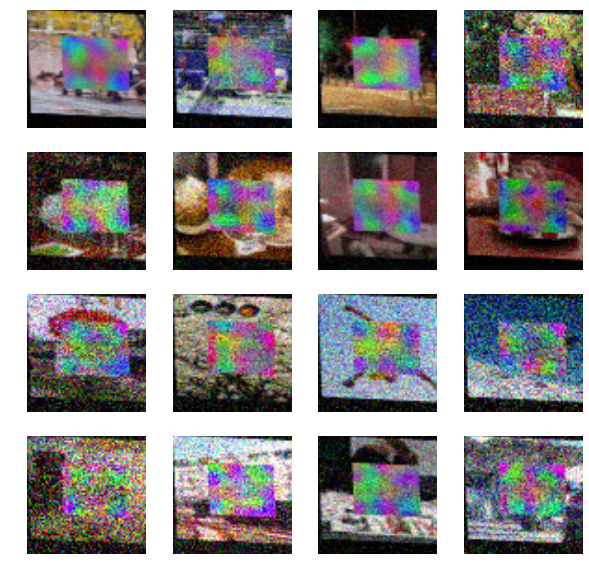

In [108]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, axi in enumerate(axs):
    for j, axj in enumerate(axi):
        img = blur_example[i * 4 + j]
        axj.imshow(np.array(img.permute(1, 2, 0).detach().numpy()),
                   interpolation='bilinear')
        axj.axis('off')

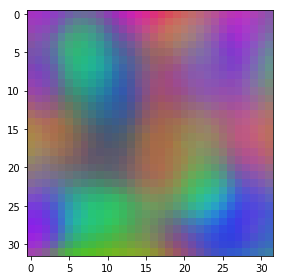

In [30]:
img = (255 * outputs[3]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);
#io.imsave('img.png', img)

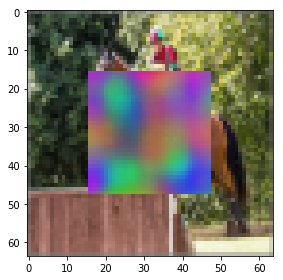

In [60]:
for batch in background_dataloader_test:
    back = batch.clone()
    back[:, :, 16:48, 16:48] = outputs
    io.imshow(back[3].permute(1, 2, 0).detach().numpy())
    break

torch.Size([16, 3, 64, 64])

In [20]:
rec_outputs = torch.sign(rec_net(outputs))
# средняя точность без трансформаций
torch.mean(torch.sum(rec_outputs == input_bit_string_batch, axis=1) / n)

tensor(1.)

### Blur

In [10]:
from kornia.filters import gaussian_blur2d
from kornia.filters import motion_blur

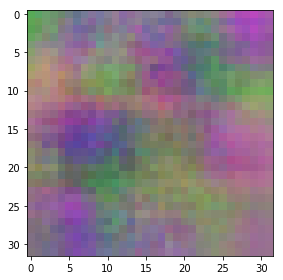

In [24]:
input_batch = outputs[2].unsqueeze(0)
gaussian_burred_img = gaussian_blur2d(input_batch, (3, 3), (0.5, 0.5))
motion_burred_img = motion_blur(input_batch, 5, 10., 1)
img = (255 * motion_burred_img[0]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

img = (255 * gaussian_burred_img[0]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

In [14]:
rec_outputs = torch.sign(rec_net_(gaussian_blur2d(outputs, (3, 3), (1., 1.))))
print('Mean accuracy for gaussian blur:')
print(torch.mean(torch.sum(rec_outputs == input_bit_string_batch, axis=1) / n))

Mean accuracy for gaussian blur:
tensor(0.9570)


In [15]:
rec_outputs = torch.sign(rec_net_(motion_blur(outputs, 5, 10., 1)))
print('Mean accuracy for gaussian blur:')
print(torch.mean(torch.sum(rec_outputs == input_bit_string_batch, axis=1) / n))

Mean accuracy for gaussian blur:
tensor(0.8906)


### Jahne noise

In [157]:
noised_outputs = outputs.clone()
for i in range(noised_outputs.shape[0]):
    std = torch.sqrt(0.003 * torch.mean(noised_outputs[i], axis=[1, 2]) + 0.0025)
    for j in range(noised_outputs[i].shape[0]):
        noised_outputs[i][j] = noised_outputs[i][j] +\
            torch.normal(torch.zeros(m, m), torch.full((32, 32), float(std[j])))

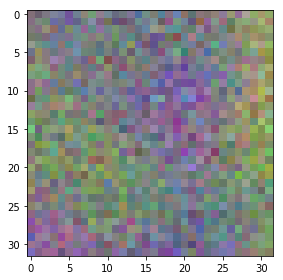

In [158]:
img = (255 * noised_outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

In [185]:
class Renderer(nn.Module):
    def __init__(self):
        super(Renderer, self).__init__()        
        self.color_jitter = K.augmentation.ColorJitter(0.15, 0.15, 0.15, 0.15, p=0.8)
  
    def forward(self, x):
        # affine transformation
        affine_sigma = np.random.uniform(0.01, 0.1, 1)
        affine_matrix = torch.tensor([[1, 0, 0], [0, 1, 0]]) +\
            torch.normal(torch.zeros(2, 3), torch.full((2, 3), float(affine_sigma)))
        x = K.geometry.transform.affine(x.float(), affine_matrix)
        
        # noise
        for i in range(x.shape[0]):
            # same parameters for each channel
            g = float(np.random.uniform(0.001, 0.003, 1))
            Jahne_sigma = float(np.random.uniform(0.001, 0.3, 1))
            std = torch.sqrt(g * torch.mean(x[i], axis=[1, 2]) + Jahne_sigma ** 2)
            for j in range(x[i].shape[0]):
                x[i][j] = x[i][j] +\
                    torch.normal(torch.zeros(m, m), torch.full((32, 32), float(std[j])))
        
        # color transformation
        x = self.color_jitter(x)
        
        # blurring
        blur_sigma = np.random.uniform(0.001, 0.5, 1)
        x = K.filters.gaussian_blur2d(x, (3, 3), (blur_sigma, blur_sigma))
        return x

In [186]:
rend_net = Renderer()
rend_outputs = rend_net(outputs)

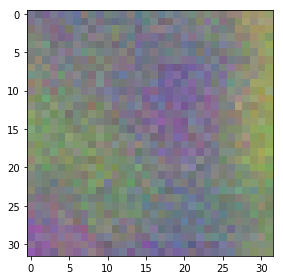

In [187]:
img = (255 * outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

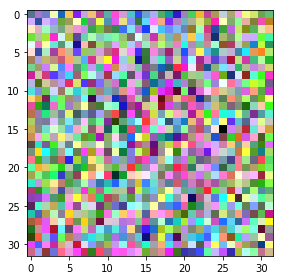

In [197]:
img = (255 * rend_outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

### Affine transformation

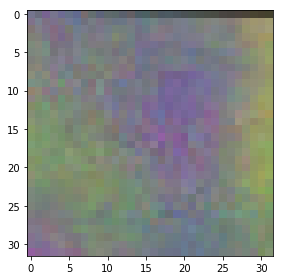

In [75]:
affine_sigma = np.random.uniform(0.01, 0.1, 1)
matrix = torch.tensor([[1, 0, 0], [0, 1, 0]]) +\
    torch.normal(torch.zeros(2, 3), torch.full((2, 3), float(affine_sigma)))

affine_outputs = K.geometry.transform.affine(outputs.float(), matrix)
img = (255 * affine_outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

### Color transformation

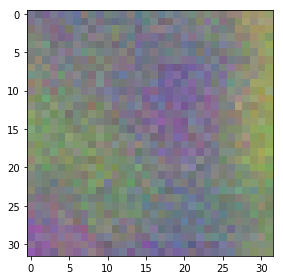

In [81]:
img = (255 * outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);

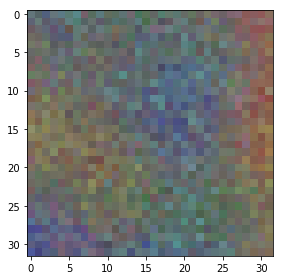

In [100]:
color_jitter = K.augmentation.ColorJitter(0.15, 0.15, 0.15, 0.15, p=0.8)
color_outputs = color_jitter(outputs)
img = (255 * color_outputs[2]).detach().numpy().transpose(1, 2, 0).astype('uint8')
io.imshow(img);